In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
import gym

In [5]:
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

LTSM Autoencoder as feature detector
n Inputs must = n of Outputs
3 months - 90 days
input layer = 90 x 5 (low, high, open, close, vol)
hidden 1 = 32?
hidden 2 = 32?
output layer = 90 x 5

Building a recurrent autoencoder is straightforward: the encoder
is typically a sequence-to-vector RNN which compresses the input
sequence down to a single vector. The decoder is a vector-to-sequence RNN
that does the reverse:

In [3]:
n_features = 5 # (low, high, open, close, vol)
window_length = 90

recurrent_encoder = keras.models.Sequential([
keras.layers.LSTM(100, return_sequences=True, input_shape=[None, n_features]),
keras.layers.LSTM(30)
])

recurrent_decoder = keras.models.Sequential([
keras.layers.RepeatVector(n_features, input_shape=[30]),
keras.layers.LSTM(100, return_sequences=True),
keras.layers.TimeDistributed(keras.layers.Dense(n_features, activation="tanh"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

2021-12-17 15:19:43.498420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-17 15:19:43.508863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-12-17 15:19:43.508884: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-17 15:19:43.509417: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [4]:
recurrent_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 30)                58120     
                                                                 
 sequential_1 (Sequential)   (None, 5, 5)              52905     
                                                                 
Total params: 111,025
Trainable params: 111,025
Non-trainable params: 0
_________________________________________________________________


In [28]:
daily_eth = pd.read_csv('../data/ETH-USD_hr_24.csv', sep=',')
#daily_eth["time"] = pd.to_datetime(daily_eth['time'], unit='s')

In [36]:
X_train = daily_eth.iloc[1:, 1:]

array([[<AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'high'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'close'}>],
       [<AxesSubplot:title={'center':'volume'}>, <AxesSubplot:>]],
      dtype=object)

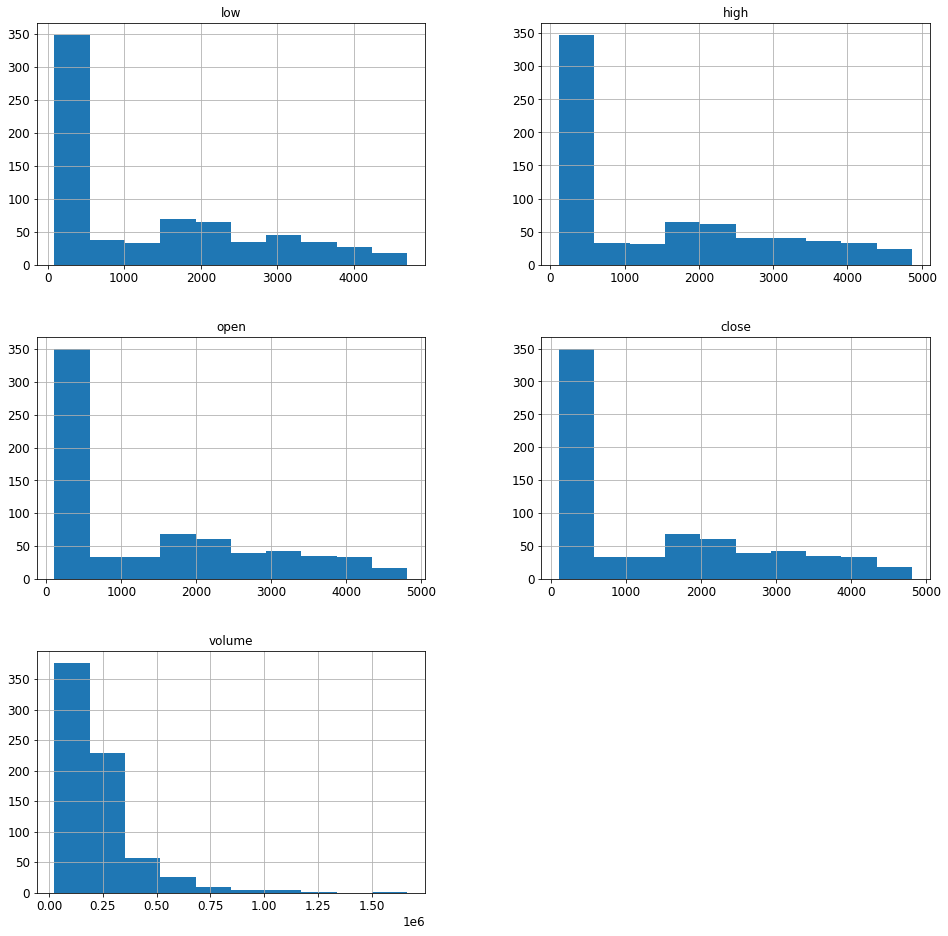

In [37]:
X_train.hist(figsize=(16, 16))

<AxesSubplot:>

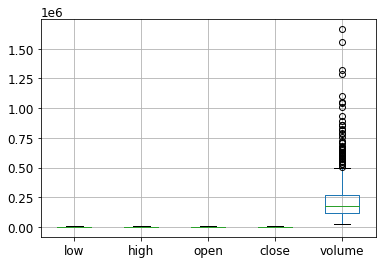

In [38]:
# very different range for each variable
X_train.boxplot()

In [42]:
X_train.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
low,711.0,1337.64,1300.97,90.00,232.76,566.00,2201.38,4697.90
high,711.0,1452.38,1403.30,118.88,244.21,607.46,2465.62,4867.81
open,711.0,1397.98,1355.14,110.30,238.76,590.45,2356.43,4811.89
close,711.0,1404.05,1359.12,110.30,239.17,591.47,2362.47,4811.90
volume,711.0,230505.38,188074.06,25941.74,117413.20,177413.91,271621.44,1664158.91


In [43]:
X_train['low'] = X_train['low'].pct_change()
X_train['high'] = X_train['high'].pct_change()
X_train['open'] = X_train['open'].pct_change()
X_train['close'] = X_train['close'].pct_change()
X_train['volume'] = X_train['volume'].pct_change()

In [44]:
X_train.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
low,710.0,0.01,0.05,-0.44,-0.02,0.01,0.03,0.34
high,710.0,0.01,0.04,-0.24,-0.01,0.00,0.03,0.29
open,710.0,0.01,0.05,-0.43,-0.02,0.00,0.03,0.26
close,710.0,0.01,0.05,-0.43,-0.02,0.01,0.03,0.26
volume,710.0,0.13,0.66,-0.78,-0.26,-0.02,0.37,5.15


array([[<AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'high'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'close'}>],
       [<AxesSubplot:title={'center':'volume'}>, <AxesSubplot:>]],
      dtype=object)

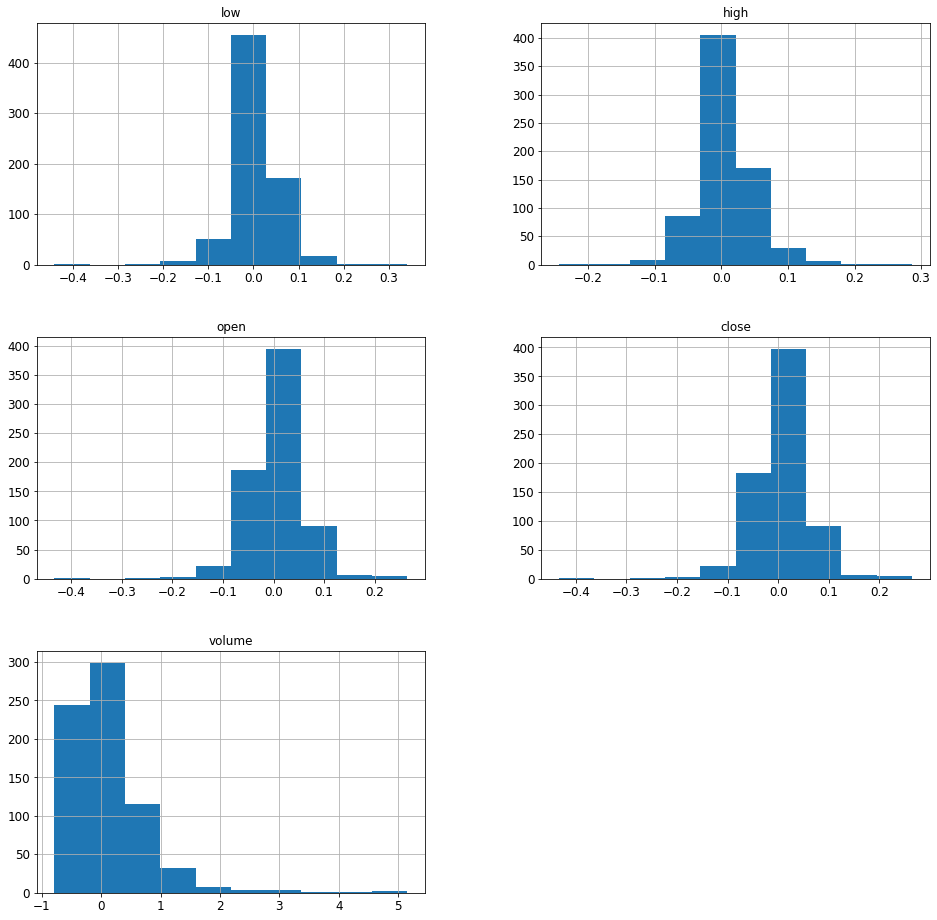

In [46]:
X_train.hist(figsize=(16, 16))

<AxesSubplot:>

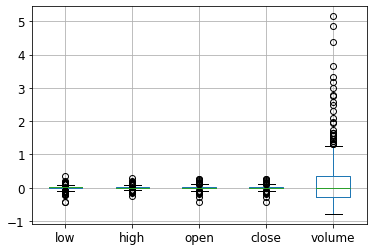

In [45]:
X_train.boxplot()